# Simulazione diffusione Compton multipla per fotoni emessi da una sorgente di Cesio

Questo programma simula la diffusione Compton di un fascio di fotoni all'interno di un cristallo del detector.

In [1]:
import numpy as np
import matplotlib.pyplot as plt
#%matplotlib

Definisco i parametri del problema: la massa dell'elettrone $m_e=511\,keV$ e l'energia nominale del fotone emesso dal decadimento del Cesio $E_{Cs} = 661.7\,keV$

In [2]:
m_e=551 #keV
E_init=E_Cs=661.7 #keV

Simuliamo il passaggio di un grande numero (10000) di fotoni;stiaimo che una frazione $P_{twice}$ dei fotoni incidenti diffonderà due volte e escludiamo, per ora, la possibilità di una tripla diffusione.

In [3]:
N_photons=10000 #number of incident photons
#prob=0.33 #ratio of photons that scatter twice in the crystal

La formula per la sezione d'urto differenziale angolare dell'effetto Compton è nota come formula di Klein-Nishima. Se $E$ ed $E'$ sono rispettivamente l'energia del fotone incidente e diffuso, e $\theta$ è l'angolo di diffusione, vale

$$
\frac{E'}{E} = \frac{1}{1+\frac{E}{m_e}(1-\cos{\theta})}
$$
 
e

$$
\frac{d\sigma}{d\cos{\theta}} = \mathcal{A} \bigg(\frac{E'}{E}\bigg)^{2} \bigg(\frac{E}{E'} + \frac{E'}{E} - \sin^{2}{\theta}\bigg)
$$

Dove $\mathcal{A}$ è un irrilevante fattore moltiplicativo che si elide normalizzando questa distribuzione.

Imponendo $\frac{d\sigma}{d\cos{\theta}} d\cos{\theta} = \frac{d\sigma}{dE'} dE'$ otteniamo la sezione d'urto differenziale in energia, che implementiamo in una funzione nella prossima cella.

La cinematica imposta un intervallo possibile di energie del fotone diffuso che dipende dall'energia del fotone incidente $E$: $I_{E} = [\frac{m_e}{m_e + 2 E} E, E]$. Per semplificare il codice delle prossime celle, implementiamo una funzione che resistuisca un ```linspace``` di ```numpy``` in questo intervallo.

In [4]:
#range of definition of d(sigma)/d(E_out) in function of E_in (defaults to E_Cs)
def sample(E=E_init, n=1000):
    return np.linspace(0.1+(m_e*E/(m_e+2*E)), E, n)

#d(sigma)/d(E_out) with e_in (defaults to E_Cs) as a parameter, computed from the Klein-Nishima formula
def crossSection(E_out, E_in=E_init):
    x=np.arccos(m_e/E_in - m_e/E_out + 1)
    return (E_out/E_in)*(E_in/E_out + E_out/E_in - np.sin(x)*np.sin(x))

Nella prossima cella simuliamo la diffusione.

Per farlo, discretizziamo l'asse delle energie del fotone diffuso (o meglio, l'intervallo di definizione di cui sopra), e estraiamo casualmente da una distribuzione di probabilità discreta, calcolata come 
$$
\frac{d\,\sigma}{d\,E'}(E'_k)
$$

($\text{w/}\,\,E'_k \in I_{E}$) le energie dei fotoni diffusi.
Per il singolo compton, lo facciamo $N_{\gamma}*(1-P_{twice})$ volte, e immagazziniamo le differenze $E_{init} - E'$ in un array (```once```, nella cella successiva).
Dopodiché simuliamo la diffusione di tutti quei fotoni che diffondono due volte, iterando il procedimento di cui sopra ma su un numero $N_{\gamma}*P_{twice}$ di fotoni incidenti, e immagazziniamo le perdite di energia in un secondo array (```twice```, nella cella successiva).
In un terzo array (```total```) uniamo i due array precedenti. Questo array contiene i risultati della "vera" simulazione, ovvero conterrà le energie di fotoni che avranno diffuso una o due volte in un rapporto controllato $P_{twice}$.

In [5]:
once=E_init - np.array([np.random.choice(sample(),p=crossSection(sample())/crossSection(sample()).sum()) for i in range (0,N_photons)])

#total=np.append(once, twice)

In [7]:
twice=E_init - np.array([np.random.choice(sample(E),p=crossSection(sample(E),E)/crossSection(sample(E),E).sum()) for E in once+E_init])

## Istogrammi dello spettro

Di seguito utilizziamo il modulo ```pyplot``` in ```matplotlib``` per rappresentare degli istogrammi delle energie dei fotoni diffusi, per i tre casi distinti: solo singolo Compton, solo doppio Compton, singolo o doppio Compton.

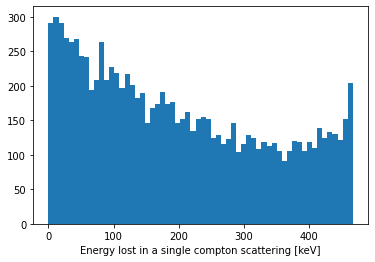

In [8]:
plt.hist(once,60)
plt.xlabel("Energy lost in a single compton scattering [keV]")
plt.savefig("/tmp/single_compton.pdf")

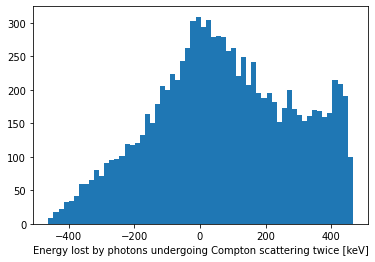

In [9]:
plt.hist(twice,60)
plt.xlabel("Energy lost by photons undergoing Compton scattering twice [keV]")
plt.savefig("/tmp/double_compton.pdf")

In [ ]:
#plt.hist(total,60)
#plt.xlabel("Energy lost in multiple compton scattering [keV]")
#plt.savefig("/tmp/compton.pdf")